# Machine Learning for Seagrass Extent Prediction

In [1]:
from pystac.client import Client
from odc.stac import load
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import joblib
from matplotlib import colors
from sklearn.ensemble import RandomForestClassifier 
import seaborn as sns
from scipy.stats import norm


from utils_test import scale, do_prediction, calculate_band_indices, apply_masks, threshold_calc_land, threshold_calc_ds

## Loading Sentinel-2 GeoMAD

Load data, then create band indices and mask out areas we don't want to include.

In [2]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [3]:
#version = "funafuti_mask_test4"

In [4]:
gdf = gpd.read_file("training-data/mal.geojson")
#version = "malekula_joined_model_mask_test3"
#gdf = gpd.read_file("training-data/Alluvium_vu_malekula_13022025.geojson")
gdf = gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]
datetime="2024"

In [5]:
items = client.search(
    collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox
).item_collection()

print(f"Found {len(items)} items")

Found 1 items


In [6]:
data = load(
    items,
    bbox=bbox,
    measurements=[
        "nir",
        "red",
        "blue",
        "green",
        "emad",
        "smad",
        "bcmad",
        "count",
        "green",
        "nir08",
        "nir09",
        "swir16",
        "swir22",
        "coastal",
        "rededge1",
        "rededge2",
        "rededge3",
    ],
    chunks={"x": 2048, "y": 2048},
)

data

<xarray.Dataset> Size: 41MB
Dimensions:      (y: 1142, x: 952, time: 1)
Coordinates:
  * y            (y) float64 9kB -1.842e+06 -1.842e+06 ... -1.854e+06 -1.854e+06
  * x            (x) float64 8kB 1.978e+06 1.978e+06 ... 1.988e+06 1.988e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/16)
    nir          (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    red          (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    blue         (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    green        (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    emad         (time, y, x) float32 4MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    smad         (time, y, x) float32 4MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    swir22       (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    coastal      (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    rededge1     (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    rededge2     (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    rededge3     (time, y, x) uint16 2MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>

# Before Masking 

In [7]:
scaled_data = scale(data)
indices = calculate_band_indices(scaled_data)

#scaled_data.odc.explore(bands=["red", "green", "blue"], vmin=0, vmax=0.3)

# Masking

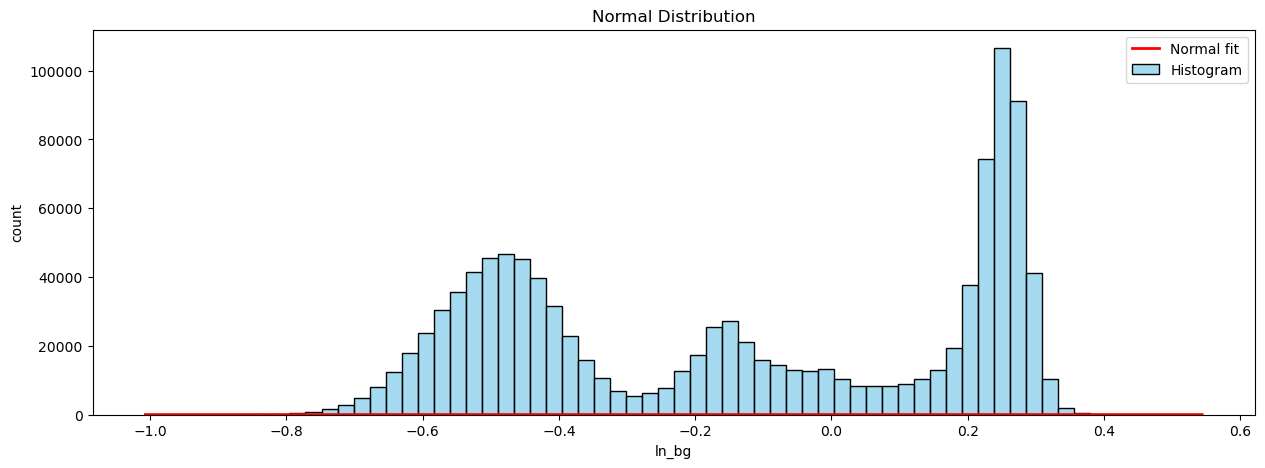

In [13]:

# Normal distribution of band, used this to check for distribution  

ln_bg = scaled_data['ln_bg'].values.flatten()  # flatten in case it's multi-dimensional

# Remove NaNs if present
ln_bg = ln_bg[~np.isnan(ln_bg)]

# Calculate mean and std
mean = ln_bg.mean()
std = ln_bg.std()

# Plot histogram
plt.figure(figsize=(15, 5))
sns.histplot(ln_bg, bins=60, kde=False, stat='count', color='skyblue', label='Histogram')

# Plot fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 10)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal fit')

plt.title('Normal Distribution')
plt.xlabel('ln_bg')
plt.ylabel('count')
plt.legend()
plt.show()

In [14]:
#Masking with josh's Threshhold function-------Land Mask

data = scaled_data

#Land Mask 0,-0.35,-0.5

mndwi = data['mndwi']
###function goes here##### #parameters = specific band, index , and level (Low,Mid,High)
level = "Low"
thresh_value = threshold_calc_land(mndwi,level) 
####################

mndwi_land_mask = mndwi > thresh_value 
masked_data = data.where(mndwi_land_mask)

In [15]:
#Masking with josh's Threshhold function-------Deep sea Mask

bg = masked_data["ln_bg"]
###function goes here##### #parameters = specific band, index , and level (Low,Mid,High)
level = "Low"
thresh_value = threshold_calc_ds(bg,level) 
####################
print(thresh_value)
mask_bg = bg < thresh_value
masked_data  = data.where(mask_bg)



0.302


In [16]:
masked_data.odc.explore(bands=["red", "green", "blue"], vmin=0, vmax=0.3)

In [17]:
#box plot vis
# ln_bg_data = data['ln_bg'].values.flatten()

# sns.boxplot(x=ln_bg_data)
# plt.xlabel('Value')
# plt.title('Boxplot of ln_bg')
# plt.show()

In [18]:
masked_data = masked_data.drop_vars(['stumpf', 'ln_bg'])
masked_data

<xarray.Dataset> Size: 204MB
Dimensions:      (time: 1, y: 1142, x: 952)
Coordinates:
  * y            (y) float64 9kB -1.842e+06 -1.842e+06 ... -1.854e+06 -1.854e+06
  * x            (x) float64 8kB 1.978e+06 1.978e+06 ... 1.988e+06 1.988e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/25)
    nir          (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    red          (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    blue         (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    green        (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    emad         (time, y, x) float32 4MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    smad         (time, y, x) float32 4MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    ...           ...
    ndvi         (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    ndwi         (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    b_g          (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    b_r          (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    mci          (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>
    ndci         (time, y, x) float64 9MB dask.array<chunksize=(1, 1142, 952), meta=np.ndarray>

# Run predictions over our region

In [19]:
model = joblib.load("models/model-geomad-joined-data-rf-11042025.model")

In [20]:
loaded = masked_data.compute()

In [21]:
loaded

<xarray.Dataset> Size: 204MB
Dimensions:      (time: 1, y: 1142, x: 952)
Coordinates:
  * y            (y) float64 9kB -1.842e+06 -1.842e+06 ... -1.854e+06 -1.854e+06
  * x            (x) float64 8kB 1.978e+06 1.978e+06 ... 1.988e+06 1.988e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/25)
    nir          (time, y, x) float64 9MB nan nan nan ... 0.0303 0.0357 0.0361
    red          (time, y, x) float64 9MB nan nan nan ... 0.0348 0.0405 0.0416
    blue         (time, y, x) float64 9MB nan nan nan ... 0.0585 0.0631 0.066
    green        (time, y, x) float64 9MB nan nan nan ... 0.0444 0.0496 0.0502
    emad         (time, y, x) float32 4MB nan nan nan ... 0.08456 0.1027 0.1055
    smad         (time, y, x) float32 4MB nan nan nan ... 1.77e-06 1.898e-06
    ...           ...
    ndvi         (time, y, x) float64 9MB nan nan nan ... -0.06299 -0.07079
    ndwi         (time, y, x) float64 9MB nan nan nan ... 0.1888 0.163 0.1634
    b_g          (time, y, x) float64 9MB nan nan nan nan ... 1.318 1.272 1.315
    b_r          (time, y, x) float64 9MB nan nan nan nan ... 1.681 1.558 1.587
    mci          (time, y, x) float64 9MB nan nan nan ... 0.773 0.8151 0.8167
    ndci         (time, y, x) float64 9MB nan nan nan ... 0.05946 0.03915 0.0303

In [22]:
predicted_da = do_prediction(loaded, model).astype(np.float32)
predicted_da

<xarray.DataArray (y: 1142, x: 952, time: 1)> Size: 4MB
array([[[nan],
        [nan],
        [nan],
        ...,
        [ 8.],
        [ 8.],
        [ 8.]],

       [[nan],
        [nan],
        [nan],
        ...,
        [ 8.],
        [ 8.],
        [ 8.]],

       [[nan],
        [nan],
        [nan],
        ...,
...
        ...,
        [ 8.],
        [ 8.],
        [ 8.]],

       [[ 8.],
        [ 8.],
        [ 8.],
        ...,
        [ 8.],
        [ 8.],
        [ 8.]],

       [[ 8.],
        [ 8.],
        [ 8.],
        ...,
        [ 8.],
        [ 8.],
        [ 8.]]], dtype=float32)
Coordinates:
  * y            (y) float64 9kB -1.842e+06 -1.842e+06 ... -1.854e+06 -1.854e+06
  * x            (x) float64 8kB 1.978e+06 1.978e+06 ... 1.988e+06 1.988e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01

# Feature Importance

In [24]:
# gdf = gpd.read_file("training-data/Alluvium_vu_malekula_13022025.geojson")
# gdf = gdf.to_crs("EPSG:4326")
# min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
# bbox = [min_lon, min_lat, max_lon, max_lat]
# datetime="2024"

In [25]:
# Define training data
#gdf = gpd.read_file("training-data/Alluvium_vu_malekula_13022025.geojson")
#gdf = gdf.to_crs("EPSG:4326")
# gdf.explore(column="cc_id", legend=True)

In [26]:
postcard =data #.where(all_masks)
# postcard =clipped_ds.to_array(dim="band")
# First transform the training points to the same CRS as the data
training = gdf.to_crs(postcard.odc.geobox.crs)

In [27]:
print(training.columns)
#training=training.drop(columns=['date', 'uuid'])

Index(['uuid', 'cc_id', 'observed', 'date', 'geometry'], dtype='object')


In [28]:
training

,uuid,cc_id,observed,date,geometry
0,16ef271d-77e7-4ff0-bd1d-a6ff0f90ec70,4,seagrass,0,POINT (-302092.206 -1057912.4)
1,54a99ed1-b4a8-48af-b4b9-8eaac71a71c9,4,seagrass,0,POINT (-302078.83 -1057913.449)
2,fe24d43f-9901-47fb-8628-34500d9cd91f,4,seagrass,0,POINT (-302078.478 -1057944.572)
3,c14141ad-da96-40e1-ae3a-9e550bc31320,4,seagrass,0,POINT (-302089.39 -1057922.891)
4,395fe142-092a-4226-9d69-3f301fb97f5f,4,seagrass,0,POINT (-302062.638 -1057910.301)
...,...,...,...,...,...
815,8f1814ed-4949-4547-bb76-69e44980fa97,10,land,0,POINT (-303113.729 -1059579.147)
816,4758ccd0-7664-4662-ba9b-238377776b9e,10,land,0,POINT (-303119.481 -1059533.436)
817,306a9316-2a7b-48dd-97a1-45a51297d855,10,land,0,POINT (-303119.481 -1059484.296)
818,029a6012-7b7e-4788-b848-75416245edb0,10,land,0,POINT (-303136.735 -1059439.728)


In [29]:
training_da = training.assign(x=training.geometry.x, y=training.geometry.y).to_xarray()

In [30]:
training_values = (
    postcard.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
training_values

,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,ndti,cai,ndvi,ndwi,b_g,b_r,mci,ndci,stumpf,ln_bg
index,,,,,,,,,,,,,,,,,,,,,
0,0.0602,0.0742,0.0926,0.1005,0.152102,1.803690e-06,0.000034,0.0031,0.0637,0.0988,...,-0.150544,-0.134804,-0.104167,0.250778,0.921393,1.247978,0.806971,0.002688,2.943602,-0.081869
1,0.0598,0.0750,0.0989,0.1071,0.161220,2.557254e-06,0.000034,0.0031,0.0648,0.0689,...,-0.176277,-0.061159,-0.112760,0.283403,0.923436,1.318667,0.801609,-0.002674,3.040499,-0.079654
2,0.0597,0.0750,0.0949,0.1040,0.161838,2.511090e-06,0.000034,0.0031,0.0667,0.0682,...,-0.162011,-0.040570,-0.113586,0.270617,0.912500,1.265333,0.777344,0.011858,2.909980,-0.091567
3,0.0597,0.0752,0.0952,0.1040,0.158307,2.317196e-06,0.000034,0.0031,0.0662,0.0687,...,-0.160714,-0.043288,-0.114900,0.270617,0.915385,1.265957,0.790728,0.001991,2.933475,-0.088411
4,0.0580,0.0723,0.0995,0.1074,0.159002,2.570254e-06,0.000034,0.0031,0.0638,0.0677,...,-0.195326,-0.061900,-0.109747,0.298670,0.926443,1.376210,0.818054,-0.009777,3.072569,-0.076403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.1775,0.0948,0.0561,0.0747,0.111034,1.623791e-06,0.000010,0.0033,0.2114,0.2068,...,0.118584,0.011454,0.303709,-0.407613,0.751004,0.591772,1.351866,0.161433,1.958911,-0.286344
816,0.2010,0.1046,0.0611,0.0830,0.098046,9.027600e-07,0.000008,0.0032,0.2511,0.1710,...,0.115139,0.051242,0.315445,-0.415493,0.736145,0.584130,1.382393,0.163200,1.972524,-0.306329
817,0.2130,0.1068,0.0609,0.0865,0.111008,9.993851e-07,0.000008,0.0030,0.2571,0.1731,...,0.105018,0.024038,0.332083,-0.422371,0.704046,0.570225,1.394892,0.176879,1.914318,-0.350911


In [31]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)
# Drop rows where there was no data available
training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,ndti,cai,ndvi,ndwi,b_g,b_r,mci,ndci,stumpf,ln_bg
0,4,0.0602,0.0742,0.0926,0.1005,0.152102,0.000002,0.000034,0.0031,0.0637,...,-0.150544,-0.134804,-0.104167,0.250778,0.921393,1.247978,0.806971,0.002688,2.943602,-0.081869
1,4,0.0598,0.0750,0.0989,0.1071,0.161220,0.000003,0.000034,0.0031,0.0648,...,-0.176277,-0.061159,-0.112760,0.283403,0.923436,1.318667,0.801609,-0.002674,3.040499,-0.079654
2,4,0.0597,0.0750,0.0949,0.1040,0.161838,0.000003,0.000034,0.0031,0.0667,...,-0.162011,-0.040570,-0.113586,0.270617,0.912500,1.265333,0.777344,0.011858,2.909980,-0.091567
3,4,0.0597,0.0752,0.0952,0.1040,0.158307,0.000002,0.000034,0.0031,0.0662,...,-0.160714,-0.043288,-0.114900,0.270617,0.915385,1.265957,0.790728,0.001991,2.933475,-0.088411
4,4,0.0580,0.0723,0.0995,0.1074,0.159002,0.000003,0.000034,0.0031,0.0638,...,-0.195326,-0.061900,-0.109747,0.298670,0.926443,1.376210,0.818054,-0.009777,3.072569,-0.076403


In [32]:
postcard_df = training_array
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'mndwi',
       'ndti', 'cai', 'ndvi', 'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'stumpf',
       'ln_bg'],
      dtype='object')

In [33]:
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'mndwi',
       'ndti', 'cai', 'ndvi', 'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'stumpf',
       'ln_bg'],
      dtype='object')

In [34]:
# postcard_df.columns
# postcard_df = postcard_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
# postcard_df = postcard_df.drop(columns=["field_1"])
# postcard_df = postcard_df.drop(columns=["y", "x", "spatial_ref"])

postcard_df = postcard_df.drop(columns=["time"])
#postcard_df

In [35]:
postcard_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,ndti,cai,ndvi,ndwi,b_g,b_r,mci,ndci,stumpf,ln_bg
0,4,0.0602,0.0742,0.0926,0.1005,0.152102,1.803690e-06,0.000034,0.0031,0.0637,...,-0.150544,-0.134804,-0.104167,0.250778,0.921393,1.247978,0.806971,0.002688,2.943602,-0.081869
1,4,0.0598,0.0750,0.0989,0.1071,0.161220,2.557254e-06,0.000034,0.0031,0.0648,...,-0.176277,-0.061159,-0.112760,0.283403,0.923436,1.318667,0.801609,-0.002674,3.040499,-0.079654
2,4,0.0597,0.0750,0.0949,0.1040,0.161838,2.511090e-06,0.000034,0.0031,0.0667,...,-0.162011,-0.040570,-0.113586,0.270617,0.912500,1.265333,0.777344,0.011858,2.909980,-0.091567
3,4,0.0597,0.0752,0.0952,0.1040,0.158307,2.317196e-06,0.000034,0.0031,0.0662,...,-0.160714,-0.043288,-0.114900,0.270617,0.915385,1.265957,0.790728,0.001991,2.933475,-0.088411
4,4,0.0580,0.0723,0.0995,0.1074,0.159002,2.570254e-06,0.000034,0.0031,0.0638,...,-0.195326,-0.061900,-0.109747,0.298670,0.926443,1.376210,0.818054,-0.009777,3.072569,-0.076403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,10,0.1775,0.0948,0.0561,0.0747,0.111034,1.623791e-06,0.000010,0.0033,0.2114,...,0.118584,0.011454,0.303709,-0.407613,0.751004,0.591772,1.351866,0.161433,1.958911,-0.286344
816,10,0.2010,0.1046,0.0611,0.0830,0.098046,9.027600e-07,0.000008,0.0032,0.2511,...,0.115139,0.051242,0.315445,-0.415493,0.736145,0.584130,1.382393,0.163200,1.972524,-0.306329
817,10,0.2130,0.1068,0.0609,0.0865,0.111008,9.993851e-07,0.000008,0.0030,0.2571,...,0.105018,0.024038,0.332083,-0.422371,0.704046,0.570225,1.394892,0.176879,1.914318,-0.350911
818,10,0.1982,0.1157,0.0670,0.0885,0.087393,5.472064e-07,0.000006,0.0028,0.2527,...,0.133203,-0.014383,0.262823,-0.382630,0.757062,0.579084,1.256020,0.153931,2.063125,-0.278310


In [36]:
len(postcard_df.columns)

31

In [37]:
# The classes are the first column
classes = np.array(postcard_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_df)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

ValueError: Input X contains infinity or a value too large for dtype('float32').

In [ ]:
postcard_params = postcard_df.columns[1:]
print(postcard_params)

In [ ]:


importances = classifier.feature_importances_

# Create the DataFrame
data = {
    'param': postcard_params,  # Use the list directly
    'importance': importances,  # Use the list directly
}
importance_df = pd.DataFrame(data)

importance_df["%"] = (importance_df["importance"]*100)

sorted_df = importance_df.sort_values(by='importance', ascending=False)
sorted_df.to_csv(f"{version}importance_df.csv")

sorted_df
# sorted_df.to_csv(.csv', index=False)

In [ ]:
sorted_df


# Visualisation
Visualise the prediction with the 8 class colour map or the 10 class colour map below, respectively

In [23]:
classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [8]
norm = colors.BoundaryNorm(bounds, c_map.N)
predicted_da.odc.explore(cmap=c_map)

In [24]:
classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#00FFFFFF"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

In [25]:
predicted_da.odc.explore(cmap=c_map)

In [26]:
version = "lowlow_test"

In [27]:
# predicted_da.odc.write_cog("predictions/predicted_ba_estuary_joined_data_postcard_svm_22042025.tiff", overwrite=True)
#predicted_da.odc.write_cog("predictions/predicted_komave_postcard_rf_24042025.tiff", overwrite=True)
predicted_da.odc.write_cog(f"predictions/{version}.tiff", overwrite=True)

PosixPath('predictions/lowlow_test.tiff')

In [57]:
predicted_da = predicted_da.where(bg < 0.2)
predicted_da.odc.explore(cmap=c_map, bands = ["red","blue","green"], vmax =0.3, vmin =0)


NameError: name 'bg' is not defined

In [ ]:
#predicted_da.rio.to_raster(f"predictions/{version}.tiff")
predicted_da_band = predicted_da.squeeze(drop=True)
predicted_da_band.rio.to_raster("output2.tiff")

# Quantitative validation (to be completed)

In [ ]:
test_data = gpd.read_file("testing-data/utanglang_postcard.geojson")
test_data.explore()

In [ ]:
print("stop here")

In [ ]:
stop_here


In [ ]:
# First transform the training points to the same CRS as the data
test = test_data.to_crs(postcard.odc.geobox.crs)
# Next get the X and Y values out of the point geometries
training_da = test.assign(x=test.geometry.x, y=test.geometry.y).to_xarray()
# Now we can use the x and y values (lon, lat) to extract values from the median composite
training_values = (
    postcard.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
len(training_values)

# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([test["observed_id"], training_values], axis=1)
training_array = training_array.drop(
    columns=[
        "y",
        "x",
        "spatial_ref",
    ]
)
# # Drop rows where there was no data available
# training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

In [ ]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([test["observed_id"], training_values], axis=1)
training_array = training_array.drop(
    columns=[
        "y",
        "x",
        "spatial_ref",
    ]
)
# # Drop rows where there was no data available
# training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

In [ ]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

In [ ]:
print(len(training_array), len(test))  # Check the lengths of both arrays

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Sample data
np.random.seed(42)
training_array = np.random.rand(100, 5)
test = pd.DataFrame({"observed_id": np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 100)})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(training_array, test.observed_id, test_size=0.9, random_state=42)

# Replace None values with a default value, e.g., 0 or the most frequent value
y_train = y_train.fillna(0)  # or y_train.fillna(y_train.mode()[0])
y_test = y_test.fillna(0)    # Ensure y_test also has no None values
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Train your model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(12, 10))  # Adjust width and height for larger plot
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
cm

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

In [ ]:
from sklearn.metrics import classification_report

# report = classification_report(true_labels, predicted_labels, target_names=class_labels)
# print(report)

report = classification_report(y_test, y_pred, target_names=['sediment', 'sand', 'rubble', 'seagrass', 'seaweed', 'coral', 'rock', 'deeps', 'mangrove', 'land'])
print(report)

In [ ]:
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

In [ ]:
print("Length of y_test:", len(y_test))
print("Length of y_pred:", len(y_pred))